In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
client = MongoClient('localhost', 27017)
db = client.TFE
collection = db.results

In [4]:
res = [res for res in collection.find({'model' : 'Attention LSTM 3.1', 'finish' : True, 'params' : {'$exists' : True}})]

In [5]:
def getBestRecall(epochs):
    currentBest = 0
    currentBestEpoch = 0
    for i, epoch in enumerate(epochs):
        if epoch['valid']['recall'] > currentBest:
            currentBest = epoch['valid']['recall']
            currentBestEpoch = i
    return epochs[currentBestEpoch]

In [6]:
def bestPrecision(epochs):
    return sorted(epochs, key = lambda x: x['valid']['clr']['weighted avg']['precision'], reverse = True)[0]

In [7]:
def bestf1(epochs):
    return sorted(epochs, key = lambda x: x['valid']['clr']['weighted avg']['f1-score'], reverse = True)[0]

In [8]:
def bestRecall(epochs):
    return sorted(epochs, key = lambda x: x['valid']['clr']['fake']['recall'], reverse = True)[0]

In [9]:
def lowerMissClass(epochs):
    return sorted(epochs, key = lambda x: x['valid']['Confusion Matrix'][1] + x['valid']['Confusion Matrix'][2], reverse = False)[0]

In [10]:
def expoAverage(array, alpha):
    newArray = [0.0 for i in range(0, len(array))]
    newArray[0] = array[0]
    for i in range(1, len(array)):
        newArray[i] = alpha * array[i] + (1-alpha) * newArray[i-1]
    return newArray

In [11]:
def precision(confMat):
    tn, fp, fn, tp = confMat
    return tp / (tp + fp)

def recall(confMat):
    tn, fp, fn, tp = confMat
    return tp / (tp + fn)

def f1(confMat):
    return 2 * (precision(confMat) * recall(confMat)) / (precision(confMat) + recall(confMat))

In [45]:
df = pd.DataFrame(columns = ['precision', 'experiment_id', 'epoch', 'SEQ_LENGTH', 'EMBEDDING_DIM', 'HIDDEN', 'LAYERS', 'DROPOUT'])
cursor = collection.find({'model' : 'Attention LSTM 3.1', 'finish' : True, 'params' : {'$exists' : True}})
for res in cursor:
    best = bestPrecision(res['result'])
    df = df.append({'precision' : best['valid']['clr']['weighted avg']['precision'], 'epoch' : best['epoch'], 
                'experiment_id' : res['experiment_id'],
                'SEQ_LENGTH' : res['params'][0]['SEQ_LENGTH'], 
                'EMBEDDING_DIM' : res['params'][0]['EMBEDDING_DIM'],
                'HIDDEN' : res['params'][0]['HIDDEN'],
                'LAYERS' : res['params'][0]['LAYERS'],
                'DROPOUT' : res['params'][0]['DROPOUT']}, ignore_index=True)
cursor.close()

In [55]:
df[df['precision'] < 0.60].sort_values(by = 'precision', ascending = False).iloc[0]

precision           0.599973
experiment_id    2431.000000
epoch             158.000000
SEQ_LENGTH         20.000000
EMBEDDING_DIM      25.000000
HIDDEN            100.000000
LAYERS              1.000000
DROPOUT             0.500000
Name: 466, dtype: float64

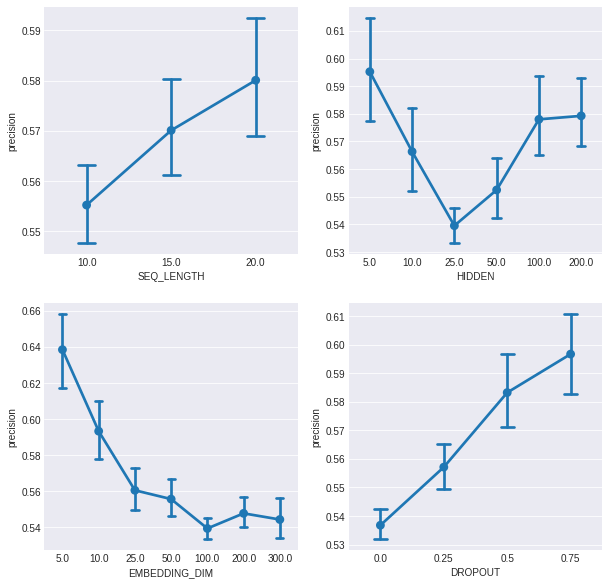

In [51]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
sns.pointplot(x = 'SEQ_LENGTH', y = 'precision', data = df, ax = axes[0][0], capsize=.2)
sns.pointplot(x = 'HIDDEN', y = 'precision', data = df, ax = axes[0][1], capsize=.2)
sns.pointplot(x = 'EMBEDDING_DIM', y = 'precision', data = df, ax = axes[1][0], capsize=.2)
sns.pointplot(x = 'DROPOUT', y = 'precision', data = df, ax = axes[1][1], capsize=.2)
plt.savefig('output/confInt_precision_liar_attention_200.pdf')

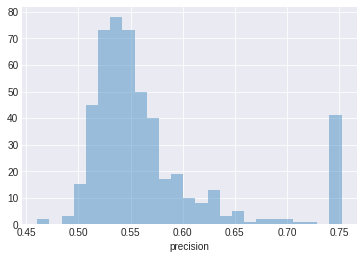

In [17]:
sns.distplot(df['precision'], bins = 25, kde = False)

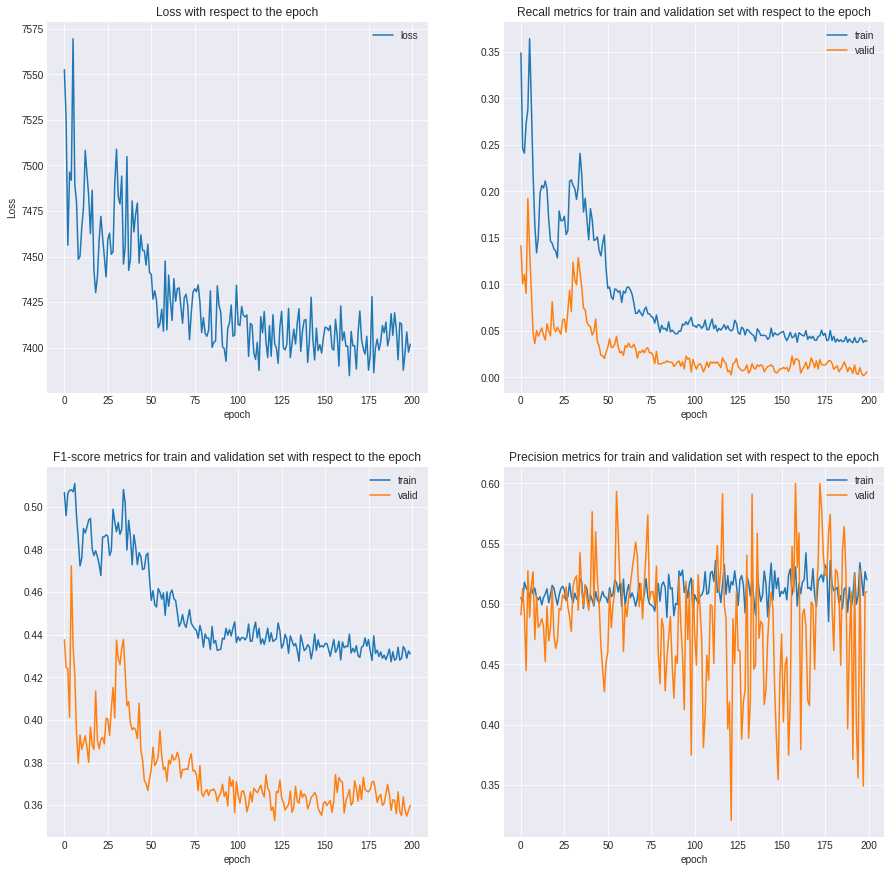

In [56]:
res = collection.find_one({'model' : 'Attention LSTM 3.1', 'experiment_id' : 2431})
train = [r['train']['recall'] for r in res['result']]
valid = [r['valid']['recall'] for r in res['result']]
loss = [r['train']['loss'] for r in res['result']]
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,15))
axes.flat[1].plot(train, label = 'train')
axes.flat[1].plot(valid, label = 'valid')
axes.flat[1].set_xlabel('epoch')
axes.flat[1].set_title('Recall metrics for train and validation set with respect to the epoch')
axes.flat[1].legend()
axes.flat[0].plot(loss, label = 'loss')
axes.flat[0].set_xlabel('epoch')
axes.flat[0].set_ylabel('Loss')
axes.flat[0].set_title('Loss with respect to the epoch')
axes.flat[0].legend()

train = [r['train']['clr']['weighted avg']['f1-score'] for r in res['result']]
valid = [r['valid']['clr']['weighted avg']['f1-score'] for r in res['result']]
axes.flat[2].plot(train, label = 'train')
axes.flat[2].plot(valid, label = 'valid')
axes.flat[2].set_xlabel('epoch')
axes.flat[2].set_title('F1-score metrics for train and validation set with respect to the epoch')
axes.flat[2].legend()

train = [r['train']['clr']['weighted avg']['precision'] for r in res['result']]
valid = [r['valid']['clr']['weighted avg']['precision'] for r in res['result']]
axes.flat[3].plot(train, label = 'train')
axes.flat[3].plot(valid, label = 'valid')
axes.flat[3].set_xlabel('epoch')
axes.flat[3].set_title('Precision metrics for train and validation set with respect to the epoch')
axes.flat[3].legend()
plt.savefig('output/appendix2_1.pdf')

In [37]:
df = pd.DataFrame(columns = ['f1-score', 'epoch', 'SEQ_LENGTH', 'EMBEDDING_DIM', 'HIDDEN', 'LAYERS', 'DROPOUT'])
cursor = collection.find({'model' : 'Attention LSTM 3.1', 'finish' : True, 'params' : {'$exists' : True}})
for res in cursor:
    best = bestf1(res['result'])
    df = df.append({'f1-score' : best['valid']['clr']['weighted avg']['f1-score'], 'epoch' : best['epoch'], 
                'SEQ_LENGTH' : res['params'][0]['SEQ_LENGTH'], 
                'EMBEDDING_DIM' : res['params'][0]['EMBEDDING_DIM'],
                'HIDDEN' : res['params'][0]['HIDDEN'],
                'LAYERS' : res['params'][0]['LAYERS'],
                'DROPOUT' : res['params'][0]['DROPOUT']}, ignore_index=True)
cursor.close()

In [38]:
df.sort_values(by = 'f1-score', ascending = False).iloc[0]

f1-score           0.564017
epoch            135.000000
SEQ_LENGTH        15.000000
EMBEDDING_DIM    300.000000
HIDDEN           100.000000
LAYERS             1.000000
DROPOUT            0.250000
Name: 441, dtype: float64

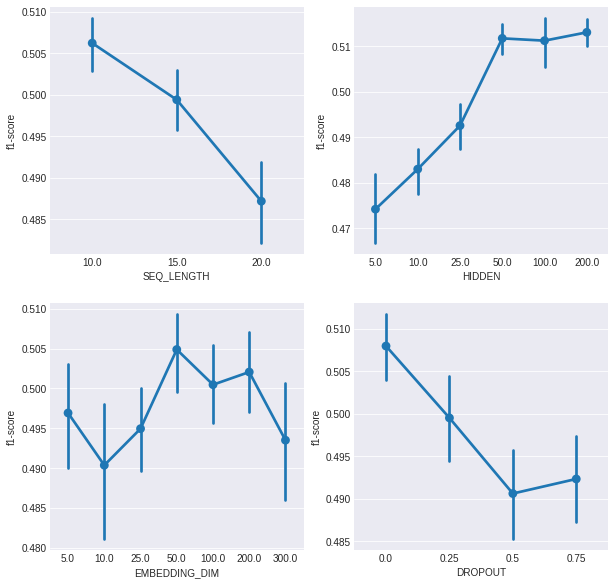

In [39]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
sns.pointplot(x = 'SEQ_LENGTH', y = 'f1-score', data = df, ax = axes[0][0])
sns.pointplot(x = 'HIDDEN', y = 'f1-score', data = df, ax = axes[0][1])
sns.pointplot(x = 'EMBEDDING_DIM', y = 'f1-score', data = df, ax = axes[1][0])
sns.pointplot(x = 'DROPOUT', y = 'f1-score', data = df, ax = axes[1][1])

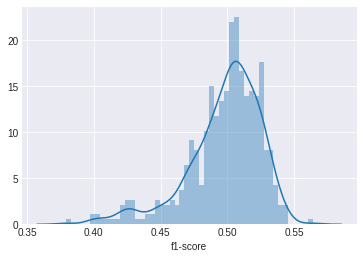

In [40]:
sns.distplot(df['f1-score'], bins = 50)

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,15))
for res in collection.find({'model' : 'Attention LSTM 3.1'}):
    train = [r['train']['clr']['weighted avg']['recall'] for r in res['result']]
    valid = [r['valid']['clr']['weighted avg']['recall'] for r in res['result']]
    loss = [r['train']['loss'] for r in res['result']]
    axes.flat[1].plot(train, label = 'train')
    axes.flat[1].plot(valid, label = 'valid')
    axes.flat[1].set_xlabel('epoch')
    axes.flat[1].set_title('Recall metrics for train and validation set with respect to the epoch')
    axes.flat[1].legend()
    axes.flat[0].plot(loss, label = 'loss')
    axes.flat[0].set_xlabel('epoch')
    axes.flat[0].set_ylabel('Loss')
    axes.flat[0].set_title('Loss with respect to the epoch')
    axes.flat[0].legend()

    train = [r['train']['clr']['weighted avg']['f1-score'] for r in res['result']]
    valid = [r['valid']['clr']['weighted avg']['f1-score'] for r in res['result']]
    axes.flat[2].plot(train, label = 'train')
    axes.flat[2].plot(valid, label = 'valid')
    axes.flat[2].set_xlabel('epoch')
    axes.flat[2].set_title('F1-score metrics for train and validation set with respect to the epoch')
    axes.flat[2].legend()

    train = [r['train']['clr']['weighted avg']['precision'] for r in res['result']]
    valid = [r['valid']['clr']['weighted avg']['precision'] for r in res['result']]
    axes.flat[3].plot(train, label = 'train')
    axes.flat[3].plot(valid, label = 'valid')
    axes.flat[3].set_xlabel('epoch')
    axes.flat[3].set_title('Precision metrics for train and validation set with respect to the epoch')
    axes.flat[3].legend()
#plt.savefig('output/attention1.pdf')

In [57]:
df = pd.DataFrame(columns = ['recall', 'experiment_id', 'epoch', 'SEQ_LENGTH', 'EMBEDDING_DIM', 'HIDDEN', 'LAYERS', 'DROPOUT'])
cursor = collection.find({'model' : 'Attention LSTM 3.1', 'finish' : True, 'params' : {'$exists' : True}})
for res in cursor:
    best = bestRecall(res['result'])
    df = df.append({'recall' : best['valid']['clr']['weighted avg']['recall'], 'epoch' : best['epoch'], 
                'experiment_id' : res['experiment_id'],
                'SEQ_LENGTH' : res['params'][0]['SEQ_LENGTH'], 
                'EMBEDDING_DIM' : res['params'][0]['EMBEDDING_DIM'],
                'HIDDEN' : res['params'][0]['HIDDEN'],
                'LAYERS' : res['params'][0]['LAYERS'],
                'DROPOUT' : res['params'][0]['DROPOUT']}, ignore_index=True)
cursor.close()

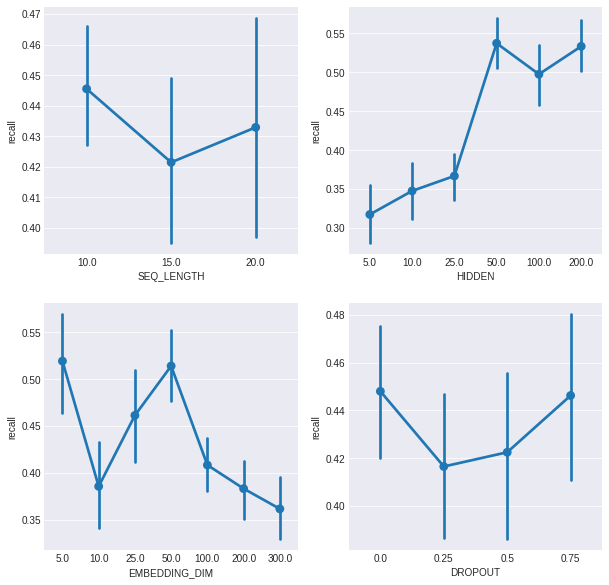

In [41]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
sns.pointplot(x = 'SEQ_LENGTH', y = 'recall', data = df, ax = axes[0][0])
sns.pointplot(x = 'HIDDEN', y = 'recall', data = df, ax = axes[0][1])
sns.pointplot(x = 'EMBEDDING_DIM', y = 'recall', data = df, ax = axes[1][0])
sns.pointplot(x = 'DROPOUT', y = 'recall', data = df, ax = axes[1][1])

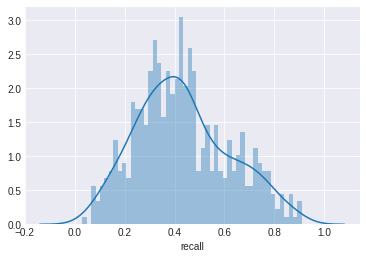

In [42]:
sns.distplot(df['recall'], bins = 50)

In [59]:
df.sort_values(by = 'recall', ascending = False).iloc[0]

recall              0.560369
experiment_id    2406.000000
epoch             199.000000
SEQ_LENGTH         15.000000
EMBEDDING_DIM     300.000000
HIDDEN            100.000000
LAYERS              1.000000
DROPOUT             0.250000
Name: 441, dtype: float64

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,15))
for res in collection.find({'model' : 'Attention LSTM 3.1'}):
    train = [r['train']['recall'] for r in res['result']]
    valid = [r['valid']['recall'] for r in res['result']]
    loss = [r['train']['loss'] for r in res['result']]
    axes.flat[1].plot(train, label = 'train')
    axes.flat[1].plot(valid, label = 'valid')
    axes.flat[1].set_xlabel('epoch')
    axes.flat[1].set_title('Recall metrics for train and validation set with respect to the epoch')
    axes.flat[1].legend()
    axes.flat[0].plot(loss, label = 'loss')
    axes.flat[0].set_xlabel('epoch')
    axes.flat[0].set_ylabel('Loss')
    axes.flat[0].set_title('Loss with respect to the epoch')
    axes.flat[0].legend()

    train = [r['train']['clr']['weighted avg']['f1-score'] for r in res['result']]
    valid = [r['valid']['clr']['weighted avg']['f1-score'] for r in res['result']]
    axes.flat[2].plot(train, label = 'train')
    axes.flat[2].plot(valid, label = 'valid')
    axes.flat[2].set_xlabel('epoch')
    axes.flat[2].set_title('F1-score metrics for train and validation set with respect to the epoch')
    axes.flat[2].legend()

    train = [r['train']['clr']['weighted avg']['precision'] for r in res['result']]
    valid = [r['valid']['clr']['weighted avg']['precision'] for r in res['result']]
    axes.flat[3].plot(train, label = 'train')
    axes.flat[3].plot(valid, label = 'valid')
    axes.flat[3].set_xlabel('epoch')
    axes.flat[3].set_title('Precision metrics for train and validation set with respect to the epoch')
    axes.flat[3].legend()
#plt.savefig('output/attention1.pdf')

In [62]:
df = pd.DataFrame(columns = ['f1-score', 'experiment_id', 'epoch', 'SEQ_LENGTH', 'EMBEDDING_DIM', 'HIDDEN', 'LAYERS', 'DROPOUT'])
cursor = collection.find({'model' : 'Attention LSTM 3.1', 'finish' : True, 'params' : {'$exists' : True}})
for res in cursor:
    best = bestRecall(res['result'])
    df = df.append({'f1-score' : best['valid']['clr']['weighted avg']['f1-score'], 'epoch' : best['epoch'], 
                'experiment_id' : res['experiment_id'],
                'SEQ_LENGTH' : res['params'][0]['SEQ_LENGTH'], 
                'EMBEDDING_DIM' : res['params'][0]['EMBEDDING_DIM'],
                'HIDDEN' : res['params'][0]['HIDDEN'],
                'LAYERS' : res['params'][0]['LAYERS'],
                'DROPOUT' : res['params'][0]['DROPOUT']}, ignore_index=True)
cursor.close()

In [67]:
df.sort_values(by = 'f1-score', ascending = False).iloc[0]

f1-score            0.55384
experiment_id    2406.00000
epoch             199.00000
SEQ_LENGTH         15.00000
EMBEDDING_DIM     300.00000
HIDDEN            100.00000
LAYERS              1.00000
DROPOUT             0.25000
Name: 441, dtype: float64

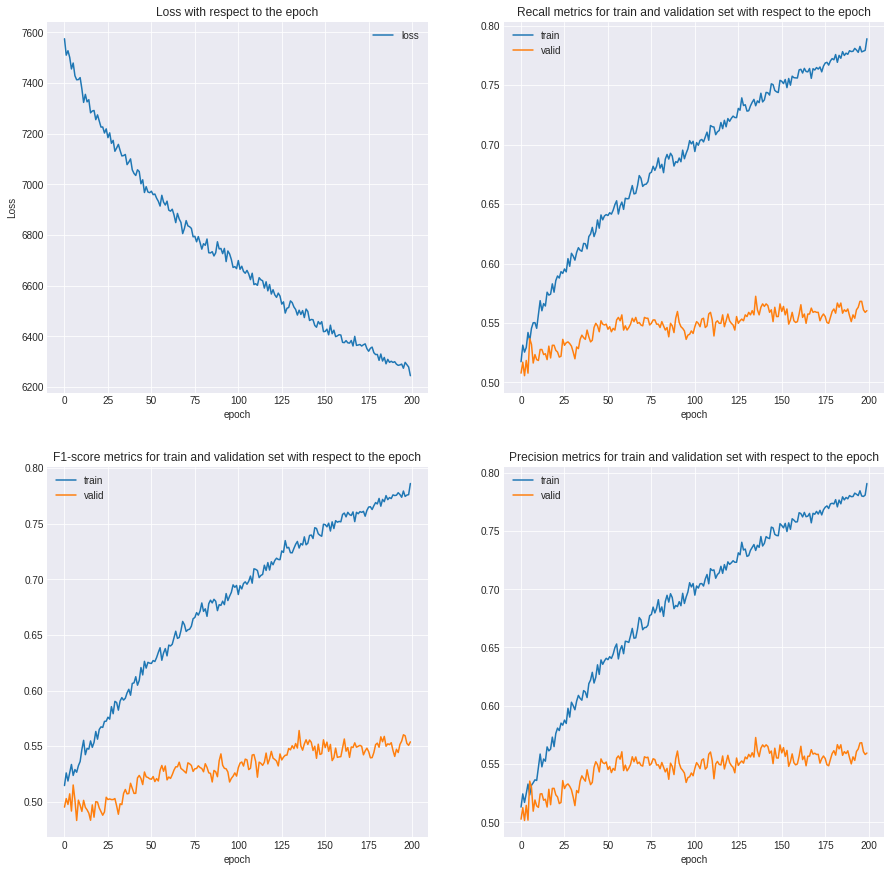

In [66]:
res = collection.find_one({'model' : 'Attention LSTM 3.1', 'experiment_id' : 2406})
train = [r['train']['clr']['weighted avg']['recall'] for r in res['result']]
valid = [r['valid']['clr']['weighted avg']['recall'] for r in res['result']]
loss = [r['train']['loss'] for r in res['result']]
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15,15))
axes.flat[1].plot(train, label = 'train')
axes.flat[1].plot(valid, label = 'valid')
axes.flat[1].set_xlabel('epoch')
axes.flat[1].set_title('Recall metrics for train and validation set with respect to the epoch')
axes.flat[1].legend()
axes.flat[0].plot(loss, label = 'loss')
axes.flat[0].set_xlabel('epoch')
axes.flat[0].set_ylabel('Loss')
axes.flat[0].set_title('Loss with respect to the epoch')
axes.flat[0].legend()

train = [r['train']['clr']['weighted avg']['f1-score'] for r in res['result']]
valid = [r['valid']['clr']['weighted avg']['f1-score'] for r in res['result']]
axes.flat[2].plot(train, label = 'train')
axes.flat[2].plot(valid, label = 'valid')
axes.flat[2].set_xlabel('epoch')
axes.flat[2].set_title('F1-score metrics for train and validation set with respect to the epoch')
axes.flat[2].legend()

train = [r['train']['clr']['weighted avg']['precision'] for r in res['result']]
valid = [r['valid']['clr']['weighted avg']['precision'] for r in res['result']]
axes.flat[3].plot(train, label = 'train')
axes.flat[3].plot(valid, label = 'valid')
axes.flat[3].set_xlabel('epoch')
axes.flat[3].set_title('Precision metrics for train and validation set with respect to the epoch')
axes.flat[3].legend()
plt.savefig('output/attention-f1.pdf')